# Adding Interaction Columns and Modeling

## Imports

In [1]:
#General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, add_dummy_feature, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from scipy.stats import norm
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer

#Hiding Pink Warnings
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Displays all columns that have missing values and the number of missing values they have

In [2]:
def display_null(df):
    #displays the columns of a data frame with null values
    for n in df.columns:
        if df[n].isnull().sum() > 0:
            print(f'{n}: {df[n].isnull().sum()}')
    pass

## Read in data from cleaned data files

In [3]:
train = pd.read_csv("../datasets/train_cleaned.csv")
test = pd.read_csv("../datasets/test_cleaned.csv")

In [4]:
display_null(train),display_null(test)

Garage Yr Blt: 114
Garage Age: 114
Garage Yr Blt: 45
Garage Age: 45


(None, None)

## Dropping Useless Columns

In [5]:
train.drop(columns = ['Unnamed: 0','Id', 'PID'],inplace=True)

In [6]:
train.isnull().sum().sum()

228

## Interaction Variables

### Creating a binary column to indicate whether a house was built before or after the year 2000

In [7]:
#Train File
train['Age'] = train['Yr Sold'] - train['Year Built']
train['SalePrice'][train['Year Built']>2000].count()
train['after2000'] = (train['Year Built']>2000)
train['after2000'] = train['after2000'].map({True:1,False:0})
train['after2000'].value_counts()
#Test File
test['Age'] = test['Yr Sold'] - test['Year Built']
test['after2000'] = (test['Year Built']>2000)
test['after2000'] = test['after2000'].map({True:1,False:0})
test['after2000'].value_counts()

0    670
1    208
Name: after2000, dtype: int64

### Creating a binary column to indicate whether a house has a garage or not

In [8]:
train['Has Garage'] = (train['Garage Yr Blt']/train['Garage Yr Blt']).fillna(0)
test['Has Garage'] = (test['Garage Yr Blt']/test['Garage Yr Blt']).fillna(0)

## Modeling

### Display Score Function
#### Displays a variety of scores to evaluate the accuracy of the model in predicting Sale Price of houses

In [9]:
def model_scores(model,X_train,X_test,y_train,y_test):
    print("R2 Accuracy Score for Training Data:", round(model.score(X_train,y_train),5))
    print("R2 Accuracy Score for Testing Data:", round(model.score(X_test,y_test),5))
    print("R2 Score of Training Data (calculated with r2_score()): ",round(r2_score(y_train,model.predict(X_train)),5))
    print("R2 Score of Testing Data (calculated with r2_score()): ",round(r2_score(y_test,model.predict(X_test)),5))
    print("Root Mean Squared Error of Training Data:", round(mean_squared_error(y_train, model.predict(X_train), squared=False),5))
    print("Root Mean Squared Error of Testing Data:", round(mean_squared_error(y_test, model.predict(X_test), squared=False),5))
    pass

### Initial Model - Only using Property size, Living space, and overall quality of the house

In [10]:
X = train[['Overall Qual','Lot Area', 'Gr Liv Area' ]]
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [11]:
ss = StandardScaler()
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train), columns=ss.get_feature_names_out())
X_test_scaled =  pd.DataFrame(ss.transform(X_test), columns=ss.get_feature_names_out())

In [12]:
base_model = LinearRegression()
base_model.fit(X_train_scaled, y_train)

LinearRegression()

### Score of initial model

accounts for 75.58% of variance in the testing data

In [13]:
model_scores(base_model,X_train_scaled,X_test_scaled,y_train,y_test)

R2 Accuracy Score for Training Data: 0.78327
R2 Accuracy Score for Testing Data: 0.7558
R2 Score of Training Data (calculated with r2_score()):  0.78327
R2 Score of Testing Data (calculated with r2_score()):  0.7558
Root Mean Squared Error of Training Data: 36915.39033
Root Mean Squared Error of Testing Data: 39034.16175


#### Given the scores for a basic model, our goal for the final model is to have an accuracy score (R2) higher than 78% and a RMSE lower than 37,000

#### Getting all possible numerical features from the data

In [14]:
num_features = [n for n in train._get_numeric_data().columns if n != 'SalePrice']
len(num_features)

53

#### Getting all possible categorical features from the data

In [15]:
cat_features = [n for n in train.columns if n not in num_features and n != 'SalePrice']
len(cat_features)

29

#### Removing Garage Age and Yr Blt because they contain nulls

In [16]:
num_features.remove('Garage Age')
num_features.remove('Garage Yr Blt')
len(num_features)

51

### Chosen Features for Models

In [17]:
#First model, hand picked numerical features
features1 = ['Overall Qual','Overall Cond','Gr Liv Area','Kitchen Qual','Lot Area','Central Air',
             'Exter Qual','Garage Cars','Bedroom AbvGr','Year Built','after2000']
#Second model, only numerical features with correlations to SalePrice higher than 0.5, with 'Has Garage Column'
features2 = ['Mas Vnr Area',
             'TotRms AbvGrd',
             'after2000',
             'Full Bath',
             'Fireplace Qu',
             'Year Remod/Add',
             'Year Built',
             'Bsmt Qual',
             '1st Flr SF',
             'Garage Cars',
             'Garage Area',
             'Total Bsmt SF',
             'Kitchen Qual',
             'Exter Qual',
             'Gr Liv Area',
             'Overall Qual',
             'Has Garage'
            ]
cat_features2 = ['Neighborhood','Alley','']  
model3 = features2+cat_features2
everything = num_features + cat_features

In [18]:
X = train[everything]
y = train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#### Transformer method for Lasso and Ridge models

In [19]:

cte1 = make_column_transformer(
    (SimpleImputer(strategy='mean'), make_column_selector(dtype_include=float)),
    (OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False,
)

#### Pipe for processing Lasso models

In [20]:
pipe1 = Pipeline([
    ('cte1', cte1),
    ('ss', StandardScaler()),
    ('lasso', Lasso())

])

#### Pipe for processing Ridge models

In [21]:
pipe2 = Pipeline([
    ('cte1', cte1),
    ('ss', StandardScaler()),
    ('ridge', Ridge())

])

#### Lasso Parameters for Cross Value Grid Search

In [22]:
pipe1.get_params();
params1 = {'lasso__alpha': np.arange(0.001, 50, 5),}
gs1 = GridSearchCV(pipe1, params1, n_jobs=-1)

gs1.fit(X_train, y_train);

#### Ridge Parameters for Cross Value Grid Search

In [23]:
pipe2.get_params().keys();
params2 = {'ridge__alpha': np.arange(0.001, 50, 5),}
gs2 = GridSearchCV(pipe2, params2, n_jobs=-1)

gs2.fit(X_train, y_train);

### Lasso CV search model scores

In [24]:
model_scores(gs1,X_train,X_test,y_train,y_test)

R2 Accuracy Score for Training Data: 0.93637
R2 Accuracy Score for Testing Data: 0.90638
R2 Score of Training Data (calculated with r2_score()):  0.93637
R2 Score of Testing Data (calculated with r2_score()):  0.90638
Root Mean Squared Error of Training Data: 20002.85091
Root Mean Squared Error of Testing Data: 24168.20534


### Lasso Model Submission

In [25]:
lasso_preds = gs1.predict(test[everything])
test['SalePrice'] = lasso_preds
submission2 = test[['Id','SalePrice']]
submission2.shape

submission2.to_csv('../datasets/submission2.csv',index=False)

### Ridge CV search model scores 

In [26]:
model_scores(gs2,X_train,X_test,y_train,y_test)

R2 Accuracy Score for Training Data: 0.93609
R2 Accuracy Score for Testing Data: 0.90557
R2 Score of Training Data (calculated with r2_score()):  0.93609
R2 Score of Testing Data (calculated with r2_score()):  0.90557
Root Mean Squared Error of Training Data: 20046.4613
Root Mean Squared Error of Testing Data: 24273.51097


#### Our CV transformed Ridge and Lasso models are our strongest models with an R2 Accuracy score of 0.90557 on our test data. This means that these models account for 90.56% of the variance in the Sale Price data. There is ever so slight overfitting in this data and slightly high variance, because our models performs noticeably (but not significantly) higher on the training data than it does on the test data.

#### Number of Features in encoded Lasso and Ridge model

In [27]:
len(gs1.best_estimator_.named_steps.ss.get_feature_names_out())

244

#### Number of Coefficients in encoded Lasso and Ridge model

In [28]:
len([coef for coef in gs1.best_estimator_.named_steps.lasso.coef_ if coef])

200

## Numerical Linear, Lasso, and Ridge Models

### Linear Regression Model using features in features1 list

In [29]:
X = train[features1]
y = train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

lr = LinearRegression()
lr.fit(X_train,y_train)
model_scores(lr,X_train, X_test, y_train, y_test)

R2 Accuracy Score for Training Data: 0.84088
R2 Accuracy Score for Testing Data: 0.81892
R2 Score of Training Data (calculated with r2_score()):  0.84088
R2 Score of Testing Data (calculated with r2_score()):  0.81892
Root Mean Squared Error of Training Data: 31630.68481
Root Mean Squared Error of Testing Data: 33613.19182


In [30]:
X = train[features2]
lr = LinearRegression()
lasso = Lasso()
ridge = Ridge()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [31]:
lr.fit(X_train,y_train)
lasso.fit(X_train,y_train)
ridge.fit(X_train,y_train)

Ridge()

### Accuracy Score for numerical feature Linear Model

In [32]:
model_scores(lr,X_train, X_test, y_train, y_test)

R2 Accuracy Score for Training Data: 0.86059
R2 Accuracy Score for Testing Data: 0.85333
R2 Score of Training Data (calculated with r2_score()):  0.86059
R2 Score of Testing Data (calculated with r2_score()):  0.85333
Root Mean Squared Error of Training Data: 29606.64454
Root Mean Squared Error of Testing Data: 30251.36753


### Accuracy Score for numerical feature Lasso Model

In [33]:
model_scores(lasso,X_train, X_test, y_train, y_test)

R2 Accuracy Score for Training Data: 0.86059
R2 Accuracy Score for Testing Data: 0.85333
R2 Score of Training Data (calculated with r2_score()):  0.86059
R2 Score of Testing Data (calculated with r2_score()):  0.85333
Root Mean Squared Error of Training Data: 29606.64542
Root Mean Squared Error of Testing Data: 30251.08712


### Accuracy Scores for numerical feature Ridge Model

In [34]:
model_scores(ridge,X_train, X_test, y_train, y_test)

R2 Accuracy Score for Training Data: 0.86059
R2 Accuracy Score for Testing Data: 0.85333
R2 Score of Training Data (calculated with r2_score()):  0.86059
R2 Score of Testing Data (calculated with r2_score()):  0.85333
Root Mean Squared Error of Training Data: 29606.6933
Root Mean Squared Error of Testing Data: 30251.48124


In [35]:
features = ['Overall Qual',
           'Overall Cond',
           'Gr Liv Area',
           'Kitchen Qual',
           'Lot Area',
           'Central Air',
           'Exter Qual',
           'Garage Cars',
           'Bedroom AbvGr',
           'Year Built',
           'after2000']

### Linear Regression Model First Attempt

In [36]:
X = train[features]
y = train['SalePrice']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)
model_scores(lr,X_train,X_test,y_train,y_test)

R2 Accuracy Score for Training Data: 0.84088
R2 Accuracy Score for Testing Data: 0.81892
R2 Score of Training Data (calculated with r2_score()):  0.84088
R2 Score of Testing Data (calculated with r2_score()):  0.81892
Root Mean Squared Error of Training Data: 31630.68481
Root Mean Squared Error of Testing Data: 33613.19182


### Linear Regression Model First Submission

In [37]:
lr1_preds = lr.predict(test[features])
test['SalePrice'] = lr1_preds
submission1 = test[['Id','SalePrice']]
submission1.shape

submission1.to_csv('../datasets/submission1.csv',index=False)

## Creating our Production Model - Addressing the Problem Statement

#### Hand Picked Categorical Features
#### Commented out variables that had no effect on the model when removed

In [38]:
model_cat_features = ['MS Zoning',
 #'Street',
 'Lot Shape',
 #'Land Contour',
 'Neighborhood',
 'Condition 1',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Exterior 1st',
 'Mas Vnr Type',
 'Foundation',
 #'Garage Type', 
 #'Garage Finish',
 #'Paved Drive',
 'Sale Type']

In [39]:
len(features2),len(model_cat_features)

(17, 11)

### Establishing Features

#### Encoding dummy variables manually since OneOneHotEncoder did not include every categorical variable and therefore made us unable to match coefficients with features

In [40]:
X = train[features2]
for n in model_cat_features:
    print("Feature:",n,"- Dropped column:",pd.get_dummies(train[n]).columns[0])
    dummy = pd.get_dummies(train[n],drop_first=True,prefix=n.upper())
    X = pd.concat([X,dummy],axis=1)
y = train['SalePrice']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

Feature: MS Zoning - Dropped column: A (agr)
Feature: Lot Shape - Dropped column: IR1
Feature: Neighborhood - Dropped column: Blmngtn
Feature: Condition 1 - Dropped column: Artery
Feature: Bldg Type - Dropped column: 1Fam
Feature: House Style - Dropped column: 1.5Fin
Feature: Roof Style - Dropped column: Flat
Feature: Exterior 1st - Dropped column: AsbShng
Feature: Mas Vnr Type - Dropped column: BrkCmn
Feature: Foundation - Dropped column: BrkTil
Feature: Sale Type - Dropped column: COD


LinearRegression()

### Encoding the categorical variables

In [41]:
#Pipeline code that refuses to include every categorical dummy and
#therefore makes coefficients unreliable despite the model being 88% accurate
"""ct = make_column_transformer(
    (OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False), model_cat_features),
    remainder = 'passthrough'
)

### Running the encoder and regression through a pipeline
pipe = Pipeline(steps=[
    ('ct',ct),
    ('scaler',StandardScaler()),
    ('lr',LinearRegression())]
)

pipe.fit(X_train,y_train);
model_scores(pipe,X_train,X_test,y_train,y_test)
pipe.named_steps.lr.coef_

ohe = OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False)
ohe.fit(train[model_cat_features])
features = ohe.get_feature_names_out().tolist() + features2

df = pd.DataFrame(zip(features,pipe.named_steps.lr.coef_),columns=['feature','coef'])
""";

### Evaluating our Production Model

Our model accounts for 90.23% of the variance in our training data and accounts for 88.11% of the variance in our test data. It is a strong model that has a slight amount of overfitting due to having a higher training score than test score.

In [42]:
model_scores(lin_reg,X_train,X_test,y_train,y_test)

R2 Accuracy Score for Training Data: 0.90193
R2 Accuracy Score for Testing Data: 0.88149
R2 Score of Training Data (calculated with r2_score()):  0.90193
R2 Score of Testing Data (calculated with r2_score()):  0.88149
Root Mean Squared Error of Training Data: 24831.98149
Root Mean Squared Error of Testing Data: 27191.8741


#### Our regression coefficents

In [43]:
coefs = lin_reg.coef_

#### Our intercept

In [44]:
lin_reg.intercept_

-832020.4238864164

### Getting feature names to match with the coefficients

In [45]:
df = pd.DataFrame(zip(X.columns,coefs),columns=['feature','coef'])
df.sort_values(by='coef',ascending=False)[df['coef']<20000].head(30)

,feature,coef
79,EXTERIOR 1ST_BrkFace,19957.646227
18,MS ZONING_FV,19801.528796
41,NEIGHBORHOOD_NPkVill,17887.034013
44,NEIGHBORHOOD_NridgHt,17861.145920
70,HOUSE STYLE_SFoyer,17760.159792
55,CONDITION 1_PosA,17043.005218
81,EXTERIOR 1ST_CemntBd,16693.453245
101,SALE TYPE_ConLD,16377.554063
91,MAS VNR TYPE_BrkFace,16235.289284
98,FOUNDATION_Wood,14849.160869


In [46]:
for i in range(df.shape[0]):
    #print(df.sort_values(by='coef',ascending=False).iloc[i],'\n')
    pass

### Residual Analysis

In [47]:
residuals = (train['SalePrice']-lin_reg.predict(X))

Text(0, 0.5, 'Residuals ($1000)')

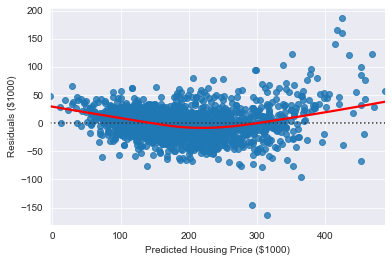

In [48]:
sns.set_style('darkgrid')
sns.residplot(x = lin_reg.predict(X)/1000, y = residuals/1000, lowess = True,line_kws = {'color':'red'})
plt.xlabel('Predicted Housing Price ($1000)')
plt.ylabel('Residuals ($1000)')

Text(0.5, 1.0, 'Linear Regression Residual Distribution')

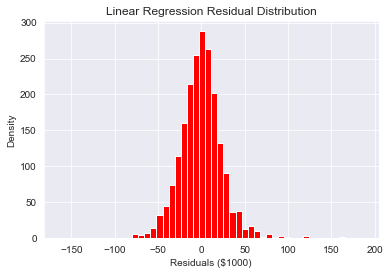

In [49]:
plt.hist(residuals/1000,bins=50,edgecolor='white',color='red');
plt.ylabel('Density')
plt.xlabel('Residuals ($1000)')
plt.title('Linear Regression Residual Distribution')

Our model's residuals are normally distributed with the tiniest skew to the left, meaning it satisfies the linear regression assumption that the errors are normally distributed.

The errors appear to be independent, not having a significant trend. The exception to this is the residuals diverging gradually after the predicted price exceeds 300,000 dollars. This is not surprising as only 7.97% of the data entries in our train dataset have a sale price greater than 300,000 dollars, so the model is not as familiar with high value houses as it is with houses sold for less than 300 thousand dollars.

In [50]:
print(train[train['SalePrice']>300000].shape,train.shape)
print(train[train['SalePrice']>300000].shape[0]/train.shape[0]*100)

(163, 83) (2045, 83)
7.970660146699267


### Conclusions

Given our linear regression model, we can predict the prices of real estate sold in Ames, Iowa from 2007 to 2010 with an model accuracy rate of 88.15%.

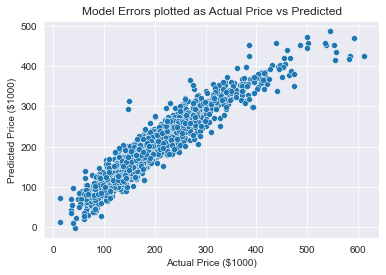

In [51]:
sns.scatterplot(x=train['SalePrice']/1000,y=lin_reg.predict(X)/1000)
plt.xlabel('Actual Price ($1000)')
plt.ylabel('Predicted Price ($1000)')
plt.title('Model Errors plotted as Actual Price vs Predicted');

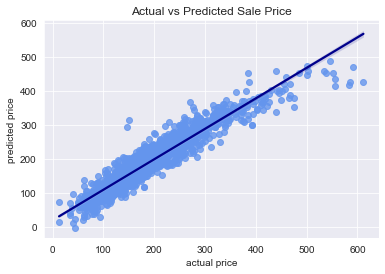

In [52]:
sns.regplot(x=train['SalePrice']/1000,y=lin_reg.predict(X)/1000,color='cornflowerblue', data=train,line_kws={'color':'darkblue'});
plt.xlabel('actual price')
plt.ylabel('predicted price')
plt.title('Actual vs Predicted Sale Price');
plt.savefig('../figures/model.png')